In [1]:
# user input
dimension = 2
conditioning_indicator = 0  # 0 = well-conditioned, 1 = ill-conditioned
noise_indicator = 1  # 0 = no noise,1 = some noise

In [2]:
# set up python
import numpy as np
from scipy import optimize as opt
import matplotlib.pyplot as plt

%matplotlib inline
from cvxpy import *

# plot properties
# use to create figures for tex
plt.rc("font", family="serif")
font = {"weight": "normal", "size": 16}
plt.rc("font", **font)

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [3]:
# define quadratic function, gradient, and Hessian for scipy.optimize

# define initial guess and coefficients a_i
x0 = np.ndarray(dimension)
x0[:2] = [4.5, -1.5]
x0[2:] = np.zeros(dimension - 2)

minimum = np.ones(dimension)
conditioning_factor = conditioning_indicator * 20
noise_coeff = 0.5 * noise_indicator
quadratic_coeff = np.array(np.exp(np.random.random(dimension) * conditioning_factor))
quadratic_coeff = quadratic_coeff / np.max(quadratic_coeff)
print(
    "condition number of Hessian of quadratic part is ",
    np.max(quadratic_coeff) / np.min(quadratic_coeff),
)

x = quadratic_coeff
cvxrun = False


def fun(x):
    return (
        0.5
        * np.sum(
            np.multiply(
                quadratic_coeff, np.square(np.array(x) - np.ones(np.array(x).size))
            )
        )
        + dimension * noise_coeff
        - noise_coeff
        * np.sum(np.cos(2 * np.pi * (np.array(x) - np.ones(np.array(x).size))))
    )


def fun_grad(x):
    return np.array(
        np.multiply(quadratic_coeff, np.array(x) - np.ones(np.array(x).size))
    ) + noise_coeff * 2 * np.pi * np.array(
        np.sin(2 * np.pi * (np.array(x) - np.ones(np.array(x).size)))
    )


def fun_hess(x):
    return np.diag(quadratic_coeff) + noise_coeff * 4 * np.square(np.pi) * np.diag(
        np.cos(2 * np.pi * (np.array(x) - np.ones(np.array(x).size)))
    )


# verify that analytical gradient is correct. returns 0 if correct
print(
    "If (close to) zero, gradient implemented correctly: ",
    opt.check_grad(fun, fun_grad, x0 * np.random.random(1)),
)
fig_suffix = (
    "dim"
    + str(dimension)
    + "_cond"
    + str(conditioning_factor)
    + "noise"
    + str(noise_indicator)
    + ".pdf"
)

condition number of Hessian of quadratic part is  1.0
If (close to) zero, gradient implemented correctly:  2.2374709507072693e-07


In [4]:
# plotting scripts for objective function

# surface plot
def plot_surf(X, Y, Z):
    fig = plt.figure()
    ax = fig.gca(projection="3d")

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)

    plt.xlabel("variable $x_1$")
    plt.ylabel("variable $x_2$")
    # Add a color bar which maps values to colors.
    fig.colorbar(surf)
    # plt.title('function to minimize, dimension = %d, a = %1.2f' % (dimension, conditioning_factor)
    plt.title("objective function")

    # plt.savefig('fig/1d-fit-ls3d.pdf')
    return plt


# contour plot with optimization iterates
def plot_contour(allvecs, legend_path):
    fig = plt.figure()
    # contour_levels=np.logspace(-0.5,3.5,5,base=10)
    # CS = plt.contour(X,Y,Z,levels=contour_levels)
    CS = plt.contour(X, Y, Z)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.title("objective function")
    plt.xlabel("variable $x_1$")
    plt.ylabel("variable $x_2$")
    plt.rc("text", usetex=False)
    plt.rc("font", family="serif")
    plt.plot(minimum[0], minimum[1], "r*", markersize=10, label="minimum")
    plt.plot(x0[0], x0[1], "bx", markersize=10, label="initial guess")
    plt.plot(
        np.array(allvecs)[:, 0],
        np.array(allvecs)[:, 1],
        "go",
        markersize=4,
        label=legend_path,
    )
    plt.legend()
    return plt

In [5]:
# create data to visualize objective function
n = 50  # number of discretization points along the x-axis
m = 50  # number of discretization points along the x-axis
a = -2.0
b = 5.0  # extreme points in the x-axis
c = -2
d = 5.0  # extreme points in the y-axis

X, Y = np.meshgrid(np.linspace(a, b, n), np.linspace(c, d, m))
Z = np.zeros(X.shape)

argument = np.zeros(x0.size)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        argument[0] = X[i, j]
        argument[1] = Y[i, j]
        argument[2:] = np.ones(x0.size - 2)
        Z[i][j] = fun(argument)

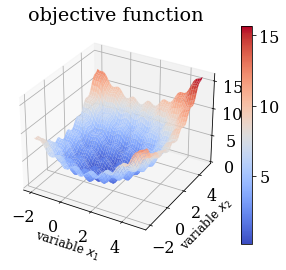

In [6]:
plt = plot_surf(X, Y, Z)

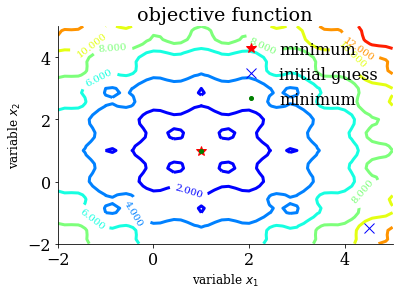

In [9]:
plt = plot_contour(np.array([[1, 1]]), "minimum")

# initialize data to store number of function evals
nfev = list()
name = list()
distance = list()

Optimization terminated successfully.
         Current function value: 6.163690
         Iterations: 8
         Function evaluations: 17
         Gradient evaluations: 17


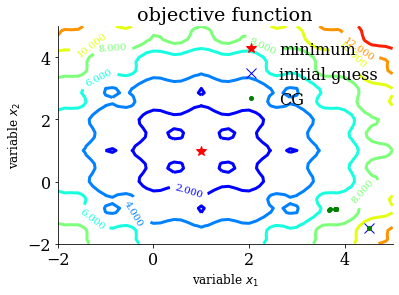

In [10]:
method_name = "CG"
method_name_legend = method_name
res = opt.minimize(
    fun, x0, method="CG", jac=fun_grad, options={"disp": True, "return_all": True}
)
plot_contour(res.allvecs, method_name_legend)
nfev = nfev + [res.nfev]
name = name + [method_name_legend]
distance = distance + [np.linalg.norm(res.x - minimum) / np.linalg.norm(minimum)]

Optimization terminated successfully.
         Current function value: 6.163690
         Iterations: 8
         Function evaluations: 51
         Gradient evaluations: 17


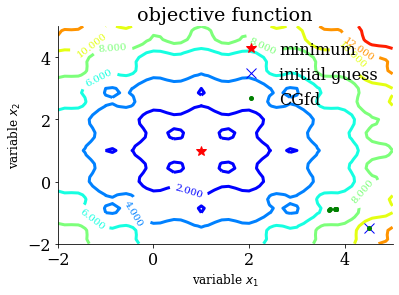

In [11]:
method_name = "CG"
method_name_legend = method_name + "fd"
res = opt.minimize(fun, x0, method="CG", options={"disp": True, "return_all": True})
plot_contour(res.allvecs, method_name_legend)
nfev = nfev + [res.nfev]
name = name + [method_name_legend]
distance = distance + [np.linalg.norm(res.x - minimum) / np.linalg.norm(minimum)]

Optimization terminated successfully.
         Current function value: 3.800814
         Iterations: 7
         Function evaluations: 11
         Gradient evaluations: 11
         Hessian evaluations: 7


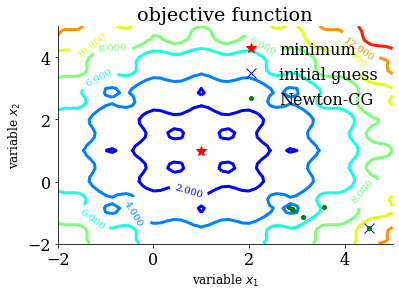

In [12]:
method_name = "Newton-CG"
method_name_legend = method_name
res = opt.minimize(
    fun,
    x0,
    method=method_name,
    jac=fun_grad,
    hess=fun_hess,
    options={"disp": True, "return_all": True},
)
plot_contour(res.allvecs, method_name_legend)
nfev = nfev + [res.nfev]
name = name + [method_name_legend]
distance = distance + [np.linalg.norm(res.x - minimum) / np.linalg.norm(minimum)]

Optimization terminated successfully.
         Current function value: 4.263283
         Iterations: 36
         Function evaluations: 71


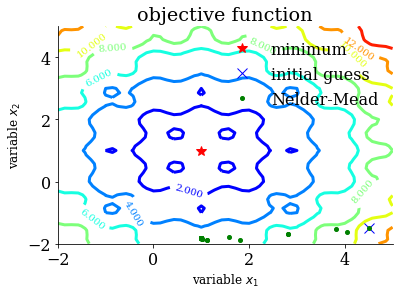

In [13]:
# minimize
method_name = "Nelder-Mead"
method_name_legend = method_name
res = opt.minimize(
    fun,
    x0,
    method=method_name,
    options={"disp": True, "return_all": True, "maxfev": 10000},
)
plot_contour(res.allvecs, method_name_legend)
nfev = nfev + [res.nfev]
name = name + [method_name_legend]
distance = distance + [np.linalg.norm(res.x - minimum) / np.linalg.norm(minimum)]

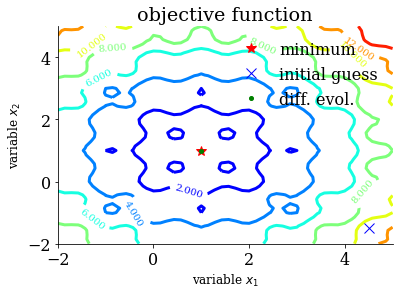

In [14]:
# minimize
method_name = "diff. evol."
method_name_legend = method_name
bounds = np.ndarray([minimum.size, 2])
bounds[:, 0] = -10 * np.ones(minimum.size)
bounds[:, 1] = 10 * np.ones(minimum.size)
res = opt.differential_evolution(fun, bounds)
sol = np.array([[res.x[0]], [res.x[1]]])
plot_contour(sol.T, method_name_legend)
nfev = nfev + [res.nfev]
name = name + [method_name_legend]
distance = distance + [np.linalg.norm(res.x - minimum) / np.linalg.norm(minimum)]

In [15]:
if noise_coeff == 0:
    import cvxpy as cvx

    method_name_legend = "CVXPY"
    x = cvx.Variable(dimension)
    quadratic_coeff_cvx = cvx.Parameter(dimension, nonneg=True)
    quadratic_coeff_cvx.value = quadratic_coeff
    obj = cvx.Minimize(0.5 * quadratic_coeff.T * cvx.square(x - 1))
    prob = cvx.Problem(obj)
    prob.solve()
    plot_contour([x.value[:2]], method_name_legend)
    distance = distance + [np.linalg.norm(res.x - minimum) / np.linalg.norm(minimum)]
    cvxrun = True

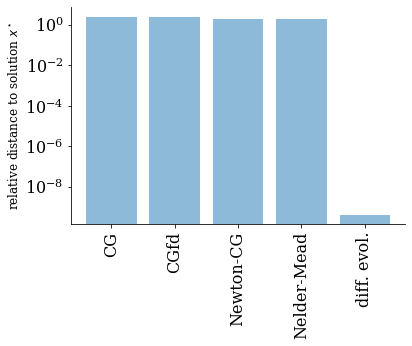

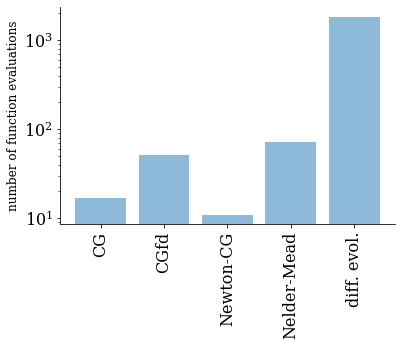

In [16]:
# bar plots of results
y_pos = np.arange(len(distance))
plt.bar(y_pos, distance, align="center", alpha=0.5, log=1)
if cvxrun:
    plt.xticks(y_pos, name + ["CVXPY"], rotation="vertical")
else:
    plt.xticks(y_pos, name, rotation="vertical")
plt.ylabel("relative distance to solution $x^\star$")
plt.show()

y_pos = np.arange(len(name))
plt.bar(y_pos, nfev, align="center", alpha=0.5, log=1)
plt.xticks(y_pos, name, rotation="vertical")
plt.ylabel("number of function evaluations")
plt.show()